# 웹 검색 모듈 추가

**절차**

1. Naive RAG 수행
2. 검색된 문서에 대한 관련성 체크(Groundedness Check)
3. (이번 튜토리얼) Web Search 추가

**참고**

- 이전 튜토리얼에서 확장된 내용이므로, 겹치는 부분이 있을 수 있습니다. 부족한 설명은 이전 튜토리얼을 참고해주세요.

![langgraph-web-search](assets/langgraph-web-search.png)

## 환경 설정

In [1]:
# !pip install -U langchain-teddynote

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Structures")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Structures


## 기본 PDF 기반 Retrieval Chain 생성

여기서는 PDF 문서를 기반으로 Retrieval Chain 을 생성합니다. 가장 단순한 구조의 Retrieval Chain 입니다.

단, LangGraph 에서는 Retirever 와 Chain 을 따로 생성합니다. 그래야 각 노드별로 세부 처리를 할 수 있습니다.

**참고**

- 이전 튜토리얼에서 다룬 내용이므로, 자세한 설명은 생략합니다.

In [3]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

# retriever와 chain을 생성합니다.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

## State 정의

`State`: Graph 의 노드와 노드 간 공유하는 상태를 정의합니다.

일반적으로 `TypedDict` 형식을 사용합니다.

이번에는 상태(State)에 관련성(relevance) 체크 결과를 추가합니다.

In [4]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages


# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)
    relevance: Annotated[str, "Relevance"]  # 관련성

## 노드(Node) 정의

- `Nodes`: 각 단계를 처리하는 노드입니다. 보통은 Python 함수로 구현합니다. 입력과 출력이 상태(State) 값입니다.
  
**참고**  

- `State`를 입력으로 받아 정의된 로직을 수행한 후 업데이트된 `State`를 반환합니다.

In [5]:
from langchain_openai import ChatOpenAI
from langchain_teddynote.evaluator import GroundednessChecker
from langchain_teddynote.messages import messages_to_history
from rag.utils import format_docs


# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = pdf_retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs)


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]

    # 체인을 호출하여 답변을 생성합니다.
    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return GraphState(
        answer=response, messages=[("user", latest_question), ("assistant", response)]
    )


# 관련성 체크 노드
def relevance_check(state: GraphState) -> GraphState:
    # 관련성 평가기를 생성합니다.
    question_answer_relevant = GroundednessChecker(
        llm=ChatOpenAI(model="gpt-4o-mini", temperature=0), target="question-retrieval"
    ).create()

    # 관련성 체크를 실행("yes" or "no")
    response = question_answer_relevant.invoke(
        {"question": state["question"], "context": state["context"]}
    )

    print("==== [RELEVANCE CHECK] ====")
    print(response.score)

    # 참고: 여기서의 관련성 평가기는 각자의 Prompt 를 사용하여 수정할 수 있습니다. 여러분들의 Groundedness Check 를 만들어 사용해 보세요!
    return GraphState(relevance=response.score)


# 관련성 체크하는 함수(router)
def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "yes":
        return "relevant"
    else:
        return "not relevant"

## 검색 노드 추가

이번에는 `TavilySearch` 도구를 사용하여 Web Search 를 수행합니다.

아래는 `TavilySearch` 도구를 사용한 예제입니다.

In [6]:
from langchain_teddynote.tools.tavily import TavilySearch

# 검색 도구 생성
tavily_tool = TavilySearch()

search_query = "2024년 노벨 문학상 수상자는?"

# 다양한 파라미터를 사용한 검색 예제
search_result = tavily_tool.search(
    query=search_query,  # 검색 쿼리
    max_results=3,  # 최대 검색 결과
    format_output=True,  # 결과 포맷팅
)

# 검색 결과 출력
print(search_result)

['<document><title>2024년 노벨 문학상, 한강 수상 : r/literature - Reddit</title><url>https://www.reddit.com/r/literature/comments/1g0g8u9/2024_nobel_prize_in_literature_awarded_to_han_kang/?tl=ko</url><content>스웨덴 한림원이 2024년 노벨 문학상 수상자로 한국 작가 한강을 발표했어. 보관된 게시물입니다. 보관된 게시물에는 댓글</content></document>', '<document><title>노벨 문학상에 소설가 한강…김대중 평화상 이후 24년만에 수상</title><url>https://www.chosun.com/national/national_general/2024/10/10/4GG54C4AYBDW3EXWCK5H2EXS7I/</url><content># 노벨 문학상에 소설가 한강…김대중 평화상 이후 24년만에 수상. 한국 소설가 한강(54)이 2024년 노벨문학상 수상자로 선정됐다. 한국인이 노벨상을 수상한 것은 지난 2000년 평화상을 탄 고(故) 김대중 전 대통령에 이어 두번째다. 스웨덴 한림원은 10일(현지 시각) 한강을 노벨문학상 수상자로 선정했다고 발표하면서 선정 이유로 “역사의 트라우마에 맞서는 동시에 인간 생의 연약함을 드러내는 시적인 산문”을 꼽았다. 해당 부문에서는 그동안 1901년부터 지난해까지 116회에 걸쳐 120명이 선정됐다. 한국에서는 노벨상 시즌마다 문학상 유력 후보로 시인 고은(91) 등이 언급됐지만 실제 수상으로 이어지진 않았다. 노벨상 수상자에게는 상금 1100만 크로나(한화 약 13억4000만원)와 메달, 증서가 수여된다. 이날 문학상에 이어 오는 11일 평화상, 14일 경제학상 수상자가 발표될 예정이다. 노벨상 시상식은 알프레드 노벨의 기일인 12월 10일 스웨덴 스톡홀름(생리의학·물리·화학·문학·경제상)과 노르웨이 오슬로(평화상)에서 열린다. 한편 한강은 지난 20

검색 노드로 패키징하여 추가합니다. (함수 생성)

In [7]:
# Web Search 노드
def web_search(state: GraphState) -> GraphState:
    # 검색 도구 생성
    tavily_tool = TavilySearch()

    search_query = state["question"]

    # 다양한 파라미터를 사용한 검색 예제
    search_result = tavily_tool.search(
        query=search_query,  # 검색 쿼리
        topic="general",  # 일반 주제
        max_results=5,  # 최대 검색 결과
        format_output=True,  # 결과 포맷팅
    )

    return {"context": search_result}

## Edges

- `Edges`: 현재 `State`를 기반으로 다음에 실행할 `Node`를 결정하는 Python 함수.

일반 엣지, 조건부 엣지 등이 있습니다.

In [9]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 정의
workflow = StateGraph(GraphState)

# 노드 추가
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("llm_answer", llm_answer)

# Web Search 노드 추가
workflow.add_node("web_search", web_search)

# 엣지 추가
workflow.add_edge("retrieve", "relevance_check")  # 검색 -> 관련성 체크


# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "relevant": "llm_answer",  # 관련성이 있으면 답변을 생성합니다.
        "not relevant": "web_search",  # 관련성이 없으면 웹 검색을 수행합니다.
    },
)

workflow.add_edge("web_search", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 그래프 진입점 설정
workflow.set_entry_point("retrieve")

# 체크포인터 설정
memory = MemorySaver()

# 그래프 컴파일
app = workflow.compile(checkpointer=memory)

컴파일한 그래프를 시각화 합니다.

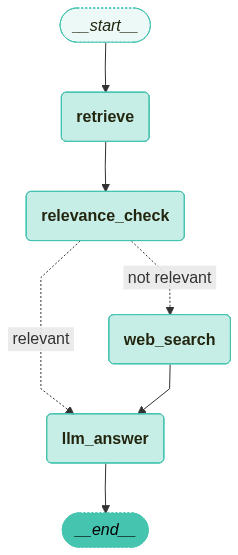

In [10]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

## 그래프 실행

- `config` 파라미터는 그래프 실행 시 필요한 설정 정보를 전달합니다.
- `recursion_limit`: 그래프 실행 시 재귀 최대 횟수를 설정합니다.
- `inputs`: 그래프 실행 시 필요한 입력 정보를 전달합니다.

검색 결과의 `relevance_check` 가 실패할 경우, 검색을 수행하여 웹 검색 결과를 제공합니다.

In [12]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid


# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="2024년 노벨 문학상 수상자는?")

# 그래프 실행
invoke_graph(app, inputs, config) # ["relevance_check", "llm_answer"]


🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>CES 2024
이번 전시에는 500곳 이상의 한국기업 참가 예정
기간 장소 홈페이지
2024.1.9~12 미국, 라스베가스 https://www.ces.tech/
- 머신러닝 및 응용에 관한 국제 컨퍼런스(AIMLA 2024)는
인공지능 및 머신러닝의 이론, 방법론 및 실용적 접근에 관한
지식과 최신 연구 결과 공유
- 이론 및 실무 측면에서 인공지능, 기계학습의 주요 분야를
논의하고, 학계, 산업계의 연구자와 실무자들에게 해당 분
AIMLA 2024
야의 최첨단 개발 소식 공유
기간 장소 홈페이지</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>22</page></document>
<document><content>n 참가국들은 튜링상을 수상한 AI 학자인 요슈아 벤지오 교수가 주도하는 ‘과학의 현황(State of
the Science)’ 보고서 작성에도 합의했으며, 보고서를 통해 첨단 AI의 위험과 가능성에 관한
기존 연구를 과학적으로 평가하고 향후 AI 안전 연구를 위한 우선순위를 제시할 계획
n 한국은 영국 정부와 6개월 뒤에 온라인으로 AI 미니 정상회의를 공동 개최하기로 합의했으며,
프랑스 정부와는 1년 후 대면 정상회의를 개최할 예정</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>6</page></document>
<document><content>12
2023년 월호</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>1</page></document>
<document><content>£AI 기술 중 머신러닝, 텐서플로우, 딥러닝의 임금 프리미엄이 높게 평가
n 

In [13]:
# 그래프 스트리밍 출력
stream_graph(app, inputs, config) # ["relevance_check", "llm_answer"]


🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"score":"no"}==== [RELEVANCE CHECK] ====
no

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
2024년 노벨 문학상 수상자는 한국 작가 한강(54)이다. 스웨덴 한림원은 그녀의 "역사의 트라우마에 맞서는 동시에 인간 생의 연약함을 드러내는 시적인 산문"을 선정 이유로 밝혔다. 한강은 2000년 김대중 전 대통령 이후 두 번째 한국인 노벨상 수상자이다.

**Source**
- [노벨 문학상에 소설가 한강…김대중 평화상 이후 24년만에 수상](https://www.chosun.com/national/national_general/2024/10/10/4GG54C4AYBDW3EXWCK5H2EXS7I/)

In [14]:
# 최종 출력 확인
outputs = app.get_state(config).values

print(f'Question: {outputs["question"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')

Question: 2024년 노벨 문학상 수상자는?
Answer:
2024년 노벨 문학상 수상자는 한국 작가 한강(54)이다. 스웨덴 한림원은 그녀의 "역사의 트라우마에 맞서는 동시에 인간 생의 연약함을 드러내는 시적인 산문"을 선정 이유로 밝혔다. 한강은 2000년 김대중 전 대통령 이후 두 번째 한국인 노벨상 수상자이다.

**Source**
- [노벨 문학상에 소설가 한강…김대중 평화상 이후 24년만에 수상](https://www.chosun.com/national/national_general/2024/10/10/4GG54C4AYBDW3EXWCK5H2EXS7I/)
